In [1]:
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
!pip install bayesian-optimization

In [3]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv1D, Flatten
import tensorflow as tf
import numpy as np
import os
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
from sklearn.preprocessing import OneHotEncoder

from bayes_opt import BayesianOptimization

In [4]:
train=pd.read_csv("./train_data.csv", encoding='cp949')
test=pd.read_csv("./test_data.csv", encoding='cp949')

## 전처리

In [5]:
#결측치 확인
def shownull(df):
    global missval_name
    print(f"데이터셋 차원 확인 \n {df.shape}")
    missval = df.isnull().sum()[df.isnull().sum()!=0]
    print(f"결측값 있는 변수 확인 \n {missval}")
    missval_name = missval.index # 결측치가 존재하는 열이 저장된 변수

#이상치 확인
def zscore_out(df, threshold = 3):
    mean = np.mean(df)
    std = np.std(df)
    z_score = np.abs((df - df.mean()) / df.std())
    outliers = np.where(z_score > threshold)
    # outlier_idx = outliers.nonzero()[0]
    print(outliers[0])

#시드고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(84)

### 결측치 대체

In [9]:
# Train set에 대해서 시간 변수 결측치 대체

train['regdate'] = pd.to_datetime(train['regdate'])

# 시작일과 종료일 설정
start_date = train['regdate'].min()  # 시작일: 2023-01-01 00:00
end_date = train['regdate'].max()  # 종료일: 2023-01-27 23:59    -------> min, max를 이용해서 data leakage 문제를 해결

# 결측치를 수정하고 이전 시간으로부터 순서대로 채워넣음
current_date = start_date  # 현재 날짜 초기화

for i in range(len(train)):
    # 결측치인 경우 이전 시간으로 대체
    if pd.isnull(train.loc[i, 'regdate']):
        train.loc[i, 'regdate'] = current_date
    
    # 다음 시간으로 이동
    current_date += timedelta(minutes=1)
    
    # 종료일인 경우 시작일로 되돌아감
    if current_date > end_date:
        current_date = start_date

#제대로 작동됨

In [10]:
# Test set에 대해서 시간 변수 결측치 대체

test['regdate'] = pd.to_datetime(test['regdate'])

# 시작일과 종료일 설정
start_date = test['regdate'].min()  # 시작일: 2023-01-01 00:00
end_date = test['regdate'].max()  # 종료일: 2023-01-27 23:59    -------> min, max를 이용해서 data leakage 문제를 해결

# 결측치를 수정하고 이전 시간으로부터 순서대로 채워넣음
current_date = start_date  # 현재 날짜 초기화

for i in range(len(test)):
    # 결측치인 경우 이전 시간으로 대체
    if pd.isnull(test.loc[i, 'regdate']):
        test.loc[i, 'regdate'] = current_date
    
    # 다음 시간으로 이동
    current_date += timedelta(minutes=1)
    
    # 종료일인 경우 시작일로 되돌아감
    if current_date > end_date:
        current_date = start_date

### 독립변수 추가

In [11]:
# TRAIN 요일 변수 추가
daysofweek = []
for i in range(len(train)) :
    dayweek = train.loc[i, 'regdate'].dayofweek
    daysofweek.append(dayweek)

train['dayofweek'] = daysofweek



#월요일 0 ~ 일요일6

<!--  -->

In [12]:
# TEST 요일 변수 추가

daysofweek = []
for i in range(len(test)) :
    dayweek = test.loc[i, 'regdate'].dayofweek
    daysofweek.append(dayweek)

test['dayofweek'] = daysofweek

In [13]:
# TRAIN 시간 -> 10진법 변환
train['time'] = train['regdate'].dt.strftime('%H:%M').str.split().str[0]
train['time'] = train['time'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))

In [14]:
# TEST 시간 -> 10진법 변환
test['time'] = test['regdate'].dt.strftime('%H:%M').str.split().str[0]
test['time'] = test['time'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))

In [15]:
it_is_not_na = np.where(~train[['PIR']].isnull())[0]

train.loc[it_is_not_na,['PIR']] = train.loc[it_is_not_na,['PIR']].astype(np.int64)

### 결측치 대체

In [16]:
# def cat_num_na(df) :

#     #변수 타입별로 분리
#     cat_na = df.select_dtypes(include=['object', 'int64'])
#     num_na = df.select_dtypes(include=['float64'])

#     #범주형 변수 최빈값으로 변환
#     for col in cat_na:
#         df[col].fillna(df[col].mode()[0], inplace=True)

#     #수치형 변수 중위값 대체
#     for col2 in num_na:
#         df[col2].fillna(df[col2].median(), inplace=True)

In [17]:
def make_area(df) :
    # 입력된 날짜 변수의 차이 계산
    date_range = df['regdate'].max() - df['regdate'].min()

    # 간격당 행의 개수 계산
    lowsbydate = ((date_range.days + 1) * 1440) #하루 1440분
    group_num = len(train) / lowsbydate

    for i in range(int(group_num)):
        start_index = i * lowsbydate
        end_index = (i + 1) * lowsbydate
        df.loc[start_index : end_index, 'area'] = i + 1

# def inter_by_area(df):
#     df.update(df.groupby('area').transform(lambda x: x.interpolate(method = 'pad')))
#     return df

In [18]:
shownull(train)

데이터셋 차원 확인 
 (388800, 14)
결측값 있는 변수 확인 
 temp           78058
humi           78058
co2            78058
dust_pm1       78058
dust_pm_25     78058
dust_pm_10     78058
illuminance    78058
voc            78058
eco2           78058
PIR            78058
dtype: int64


In [20]:
train_nona = train.copy()
# cat_num_na(train_nona)
make_area(train_nona)

test_nona = test.copy()
# cat_num_na(test_nona)
make_area(test_nona)

In [21]:
def replace_missing_with_mean(dataframe, dependent_col, independent_cols):
    for col in independent_cols:
        mean = dataframe.groupby(dependent_col)[col].transform('mean')
        dataframe[col].fillna(mean, inplace=True)

In [22]:
# 결측 값 대체
f_list=['temp','humi','co2','dust_pm1','dust_pm_25','dust_pm_10','illuminance','voc','eco2','PIR']
replace_missing_with_mean(train_nona, 'area', f_list )
replace_missing_with_mean(test_nona, 'area', f_list )

In [23]:
shownull(train_nona)
shownull(test_nona)

데이터셋 차원 확인 
 (388800, 15)
결측값 있는 변수 확인 
 Series([], dtype: int64)
데이터셋 차원 확인 
 (85000, 15)
결측값 있는 변수 확인 
 Series([], dtype: int64)


### 파일 분할 및 스케일링

In [24]:
#One-Hot Encoding
# ohe = OneHotEncoder(sparse=False)
# onehot_train = ohe.fit_transform(train_nona[['dayofweek']])
# onehot_test = ohe.transform(test_nona[['dayofweek']])

# onehot_train2 = pd.DataFrame(onehot_train, columns=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
# onehot_test2 = pd.DataFrame(onehot_test, columns=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# onehot_train3 = pd.concat([train_nona.drop('dayofweek', axis=1), onehot_train2], axis=1)
# onehot_test3 = pd.concat([test_nona.drop('dayofweek', axis=1), onehot_test2], axis=1)

In [25]:
X_train = train_nona.drop('재실인원', axis=1)
y_train = train_nona['재실인원']

X_test = test_nona.drop('재실인원', axis=1)
y_test = test_nona['재실인원']

In [26]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [27]:
#regdate 제거한 뒤 확인

X_train = X_train.drop(['regdate','area','dayofweek'], axis=1)
X_valid = X_valid.drop(['regdate','area','dayofweek'], axis=1)
X_test = X_test.drop(['regdate','area','dayofweek'], axis=1)

In [28]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [29]:
y_train = np.array(y_train)
y_valid = np.array(y_valid)
y_test = np.array(y_test)

In [30]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,10
0,0.547595,0.305575,0.187834,0.005564,0.003774,0.001962,0.028112,0.000691,0.009025,0.006605,0.774844
1,0.450382,0.486842,0.172163,0.001449,0.000980,0.000504,0.000000,0.000519,0.006982,0.000000,0.120222
2,0.547595,0.305575,0.187834,0.005564,0.003774,0.001962,0.028112,0.000691,0.009025,0.006605,0.370396
3,0.450279,0.306361,0.206783,0.018542,0.012562,0.006551,0.043305,0.001440,0.015706,0.000977,0.209173
4,0.816794,0.144737,0.349893,0.002899,0.001961,0.001009,0.050360,0.001266,0.016838,0.000000,0.072967
...,...,...,...,...,...,...,...,...,...,...,...
291595,0.549618,0.263158,0.244540,0.015942,0.010784,0.006051,0.021583,0.000504,0.006797,0.000000,0.985407
291596,0.641221,0.210526,0.166595,0.040580,0.027451,0.014120,0.057554,0.000549,0.007446,0.000000,0.054204
291597,0.603053,0.263158,0.284797,0.034783,0.023529,0.012103,0.021583,0.002472,0.032903,0.000000,0.619875
291598,0.709924,0.131579,0.253961,0.007246,0.004902,0.002521,0.079137,0.000732,0.009794,0.000000,0.991661


In [31]:
X_train = np.reshape(X_train, (len(X_train),11,1)).astype(float)
X_valid = np.reshape(X_valid, (len(X_valid),11,1)).astype(float)
X_test = np.reshape(X_test, (len(X_test),11,1)).astype(float)

In [32]:
X_train.shape

(291600, 11, 1)

## 모델 설정

In [33]:
mse =[]
def buildModel(neurons,drop,nb_batch,hidden_layers):  
    nb_epoch=5
    neurons=int(neurons)
    hidden_layers=int(hidden_layers)

    # input layer
    inputs = tf.keras.Input(shape=(11,1))
    x = tf.keras.layers.Conv1D(11,10, activation='relu')(inputs)
    x = tf.keras.layers.Flatten()(x)

    if hidden_layers !=0:
        for i in range(1,hidden_layers+1):
            x = tf.keras.layers.Dense(neurons*(2**(hidden_layers+1)), activation='relu')(x)
    x = tf.keras.layers.Dense(neurons*(2**(hidden_layers+1)),activation='relu')(x)
    x = tf.keras.layers.Dropout(drop)(x)

    # output
    predictions = Dense(1)(x)


    # modeling
    model = tf.keras.Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode="min",patience=3,restore_best_weights=True, verbose=1)



    # learning
    model.fit(X_train, y_train, epochs=int(nb_epoch), batch_size=int(nb_batch),callbacks=[early_stopping], validation_data=(X_valid, y_valid))


    # evaluate the model with test data
    loss, mse = model.evaluate(X_test, y_test)
    
    if mse < 1.0: 
        model.save(f"./model/dh/{mse}.h5")
        print("모델이 저장 되었습니다.")
        print("loss : ",loss)
        print("mse : ",mse)
    
    return mse

In [34]:
pbounds = {
        # define the range of each parameter
        'drop' : (0.5,0.9),
        "neurons" : (12,24),
        'nb_batch' : (512,1024),
        'hidden_layers' : (0,3)}

In [35]:
bo=BayesianOptimization(f=buildModel, pbounds=pbounds, verbose=2, random_state=42 )

## 학습

In [36]:
bo.maximize(
   init_points=2,
   n_iter=100
)

|   iter    |  target   |   drop    | hidden... | nb_batch  |  neurons  |
-------------------------------------------------------------------------
Epoch 1/5
330/330 [==============================] - 5s 6ms/step - loss: 1.1626 - mean_squared_error: 1.1626 - val_loss: 0.7158 - val_mean_squared_error: 0.7158
Epoch 2/5
330/330 [==============================] - 2s 6ms/step - loss: 0.7374 - mean_squared_error: 0.7374 - val_loss: 0.6392 - val_mean_squared_error: 0.6392
Epoch 3/5
330/330 [==============================] - 2s 6ms/step - loss: 0.6823 - mean_squared_error: 0.6823 - val_loss: 0.5813 - val_mean_squared_error: 0.5813
Epoch 4/5
330/330 [==============================] - 2s 6ms/step - loss: 0.6372 - mean_squared_error: 0.6372 - val_loss: 0.5768 - val_mean_squared_error: 0.5768
Epoch 5/5
2657/2657 [==============================] - 7s 3ms/step - loss: 242.5325 - mean_squared_error: 242.5325
| 1         | 242.5     | 0.6498    | 2.852     | 886.8     | 19.18     |
Epoch 1/5
540/540 [

2657/2657 [==============================] - 8s 3ms/step - loss: 199.7833 - mean_squared_error: 199.7833
| 16        | 199.8     | 0.6134    | 2.799     | 886.1     | 19.84     |
Epoch 1/5
337/337 [==============================] - 2s 5ms/step - loss: 1.8154 - mean_squared_error: 1.8154 - val_loss: 1.0133 - val_mean_squared_error: 1.0133
Epoch 2/5
337/337 [==============================] - 2s 6ms/step - loss: 1.1337 - mean_squared_error: 1.1337 - val_loss: 0.8395 - val_mean_squared_error: 0.8395
Epoch 3/5
337/337 [==============================] - 2s 6ms/step - loss: 0.9985 - mean_squared_error: 0.9985 - val_loss: 0.7845 - val_mean_squared_error: 0.7845
Epoch 4/5
337/337 [==============================] - 2s 6ms/step - loss: 0.9425 - mean_squared_error: 0.9425 - val_loss: 0.7606 - val_mean_squared_error: 0.7606
Epoch 5/5
2657/2657 [==============================] - 8s 3ms/step - loss: 4.4117 - mean_squared_error: 4.4117
| 17        | 4.412     | 0.6458    | 0.8602    | 866.4     | 20.0

Epoch 5/5
2657/2657 [==============================] - 13s 5ms/step - loss: 0.8015 - mean_squared_error: 0.8015
모델이 저장 되었습니다.
loss :  0.8014646768569946
mse :  0.8014646768569946
| 24        | 0.8015    | 0.5234    | 0.3865    | 793.8     | 22.44     |
Epoch 1/5
488/488 [==============================] - 4s 6ms/step - loss: 1.6945 - mean_squared_error: 1.6945 - val_loss: 0.8640 - val_mean_squared_error: 0.8640
Epoch 2/5
488/488 [==============================] - 3s 6ms/step - loss: 1.1831 - mean_squared_error: 1.1831 - val_loss: 0.8012 - val_mean_squared_error: 0.8012
Epoch 3/5
488/488 [==============================] - 3s 7ms/step - loss: 1.0786 - mean_squared_error: 1.0786 - val_loss: 0.7799 - val_mean_squared_error: 0.7799
Epoch 4/5
488/488 [==============================] - 3s 7ms/step - loss: 1.0194 - mean_squared_error: 1.0194 - val_loss: 0.7278 - val_mean_squared_error: 0.7278
Epoch 5/5
2657/2657 [==============================] - 11s 4ms/step - loss: 1.9879 - mean_squared_error

Epoch 4/5
330/330 [==============================] - 3s 9ms/step - loss: 0.6474 - mean_squared_error: 0.6474 - val_loss: 0.5347 - val_mean_squared_error: 0.5347
Epoch 5/5
2657/2657 [==============================] - 13s 5ms/step - loss: 138.4391 - mean_squared_error: 138.4391
| 40        | 138.4     | 0.6919    | 2.841     | 886.6     | 19.98     |
Epoch 1/5
426/426 [==============================] - 4s 8ms/step - loss: 1.1021 - mean_squared_error: 1.1021 - val_loss: 0.7241 - val_mean_squared_error: 0.7241
Epoch 2/5
426/426 [==============================] - 3s 7ms/step - loss: 0.8033 - mean_squared_error: 0.8033 - val_loss: 0.6523 - val_mean_squared_error: 0.6523
Epoch 3/5
426/426 [==============================] - 3s 8ms/step - loss: 0.7150 - mean_squared_error: 0.7150 - val_loss: 0.5711 - val_mean_squared_error: 0.5711
Epoch 4/5
426/426 [==============================] - 3s 8ms/step - loss: 0.6343 - mean_squared_error: 0.6343 - val_loss: 0.5064 - val_mean_squared_error: 0.5064
Epoch

Epoch 3/5
330/330 [==============================] - 3s 8ms/step - loss: 0.8093 - mean_squared_error: 0.8093 - val_loss: 0.6559 - val_mean_squared_error: 0.6559
Epoch 4/5
330/330 [==============================] - 3s 8ms/step - loss: 0.7495 - mean_squared_error: 0.7495 - val_loss: 0.5696 - val_mean_squared_error: 0.5696
Epoch 5/5
2657/2657 [==============================] - 15s 6ms/step - loss: 7.5206 - mean_squared_error: 7.5206
| 56        | 7.521     | 0.813     | 2.724     | 886.7     | 19.13     |
Epoch 1/5
333/333 [==============================] - 4s 9ms/step - loss: 1.1764 - mean_squared_error: 1.1764 - val_loss: 0.6949 - val_mean_squared_error: 0.6949
Epoch 2/5
333/333 [==============================] - 3s 9ms/step - loss: 0.7517 - mean_squared_error: 0.7517 - val_loss: 0.6298 - val_mean_squared_error: 0.6298
Epoch 3/5
333/333 [==============================] - 3s 9ms/step - loss: 0.6712 - mean_squared_error: 0.6712 - val_loss: 0.5462 - val_mean_squared_error: 0.5462
Epoch 4/5

Epoch 2/5
353/353 [==============================] - 2s 7ms/step - loss: 1.6975 - mean_squared_error: 1.6975 - val_loss: 1.1229 - val_mean_squared_error: 1.1229
Epoch 3/5
353/353 [==============================] - 3s 7ms/step - loss: 1.4555 - mean_squared_error: 1.4555 - val_loss: 1.0268 - val_mean_squared_error: 1.0268
Epoch 4/5
353/353 [==============================] - 2s 7ms/step - loss: 1.3257 - mean_squared_error: 1.3257 - val_loss: 0.9626 - val_mean_squared_error: 0.9626
Epoch 5/5
2657/2657 [==============================] - 10s 4ms/step - loss: 3.5111 - mean_squared_error: 3.5111
| 72        | 3.511     | 0.8663    | 0.7565    | 827.4     | 14.26     |
Epoch 1/5
354/354 [==============================] - 3s 6ms/step - loss: 1.8307 - mean_squared_error: 1.8307 - val_loss: 1.1043 - val_mean_squared_error: 1.1043
Epoch 2/5
354/354 [==============================] - 2s 6ms/step - loss: 1.1687 - mean_squared_error: 1.1687 - val_loss: 0.9013 - val_mean_squared_error: 0.9013
Epoch 3/5

Epoch 1/5
294/294 [==============================] - 2s 5ms/step - loss: 2.1125 - mean_squared_error: 2.1125 - val_loss: 1.2462 - val_mean_squared_error: 1.2462
Epoch 2/5
294/294 [==============================] - 2s 6ms/step - loss: 1.3525 - mean_squared_error: 1.3525 - val_loss: 1.0182 - val_mean_squared_error: 1.0182
Epoch 3/5
294/294 [==============================] - 2s 6ms/step - loss: 1.1985 - mean_squared_error: 1.1985 - val_loss: 0.9172 - val_mean_squared_error: 0.9172
Epoch 4/5
294/294 [==============================] - 2s 7ms/step - loss: 1.0722 - mean_squared_error: 1.0722 - val_loss: 0.8425 - val_mean_squared_error: 0.8425
Epoch 5/5
2657/2657 [==============================] - 10s 4ms/step - loss: 19.1507 - mean_squared_error: 19.1507
| 88        | 19.15     | 0.6136    | 0.147     | 995.8     | 16.67     |
Epoch 1/5
426/426 [==============================] - 4s 8ms/step - loss: 1.0282 - mean_squared_error: 1.0282 - val_loss: 0.6844 - val_mean_squared_error: 0.6844
Epoch 2

Epoch 1/5
291/291 [==============================] - 3s 7ms/step - loss: 1.2233 - mean_squared_error: 1.2233 - val_loss: 0.7324 - val_mean_squared_error: 0.7324
Epoch 2/5
291/291 [==============================] - 3s 11ms/step - loss: 0.7942 - mean_squared_error: 0.7942 - val_loss: 0.6756 - val_mean_squared_error: 0.6756
Epoch 3/5
291/291 [==============================] - 2s 8ms/step - loss: 0.7265 - mean_squared_error: 0.7265 - val_loss: 0.6197 - val_mean_squared_error: 0.6197
Epoch 4/5
291/291 [==============================] - 2s 7ms/step - loss: 0.6721 - mean_squared_error: 0.6721 - val_loss: 0.5701 - val_mean_squared_error: 0.5701
Epoch 5/5
2657/2657 [==============================] - 10s 4ms/step - loss: 35.1732 - mean_squared_error: 35.1732
| 96        | 35.17     | 0.6533    | 2.875     | 1.004e+03 | 18.37     |
Epoch 1/5
340/340 [==============================] - 3s 7ms/step - loss: 1.0986 - mean_squared_error: 1.0986 - val_loss: 0.7006 - val_mean_squared_error: 0.7006
Epoch 

In [37]:
best_param=bo.res[23]['params']
best_param

{'drop': 0.5233643407780469,
 'hidden_layers': 0.38648080556972186,
 'nb_batch': 793.7999516118144,
 'neurons': 22.435416267184642}

In [38]:
reconstructed_model = keras.models.load_model("./model/dh/0.8014646768569946.h5")

## MSE 값

In [39]:
reconstructed_model.evaluate(X_test, y_test)

2657/2657 [==============================] - 7s 2ms/step - loss: 0.8015 - mean_squared_error: 0.8015


[0.8014646768569946, 0.8014646768569946]

## RMSE 값

In [40]:
np.sqrt(reconstructed_model.evaluate(X_test, y_test))

2657/2657 [==============================] - 8s 3ms/step - loss: 0.8015 - mean_squared_error: 0.8015


array([0.8952456, 0.8952456])

In [41]:
Y_train_pred = reconstructed_model.predict(X_train)
Y_test_pred = reconstructed_model.predict(X_test)

2657/2657 [==============================] - 5s 2ms/step


In [42]:
y_test=y_test.reshape(-1,1)

In [43]:
y_train=y_train.reshape(-1,1)

## 시각화

In [44]:
import matplotlib.pyplot as plt
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    if graph_on == True:
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6),
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    return Score, Residual

def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te

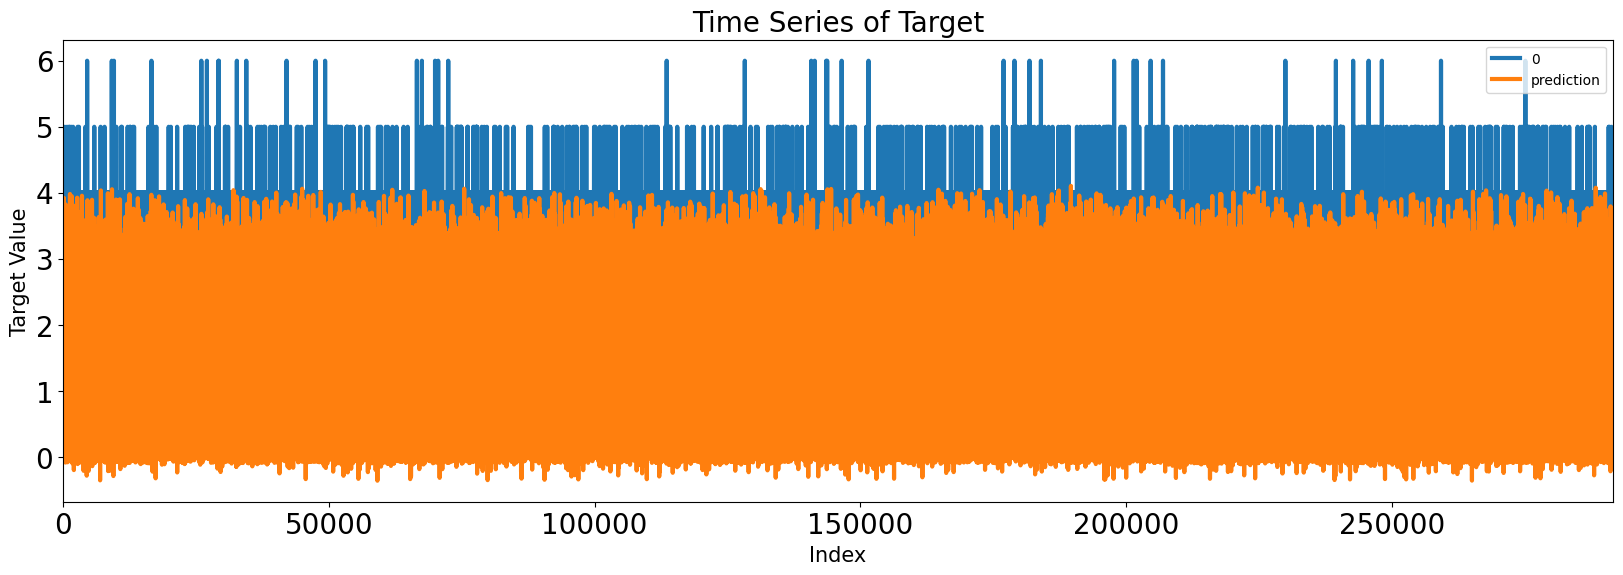

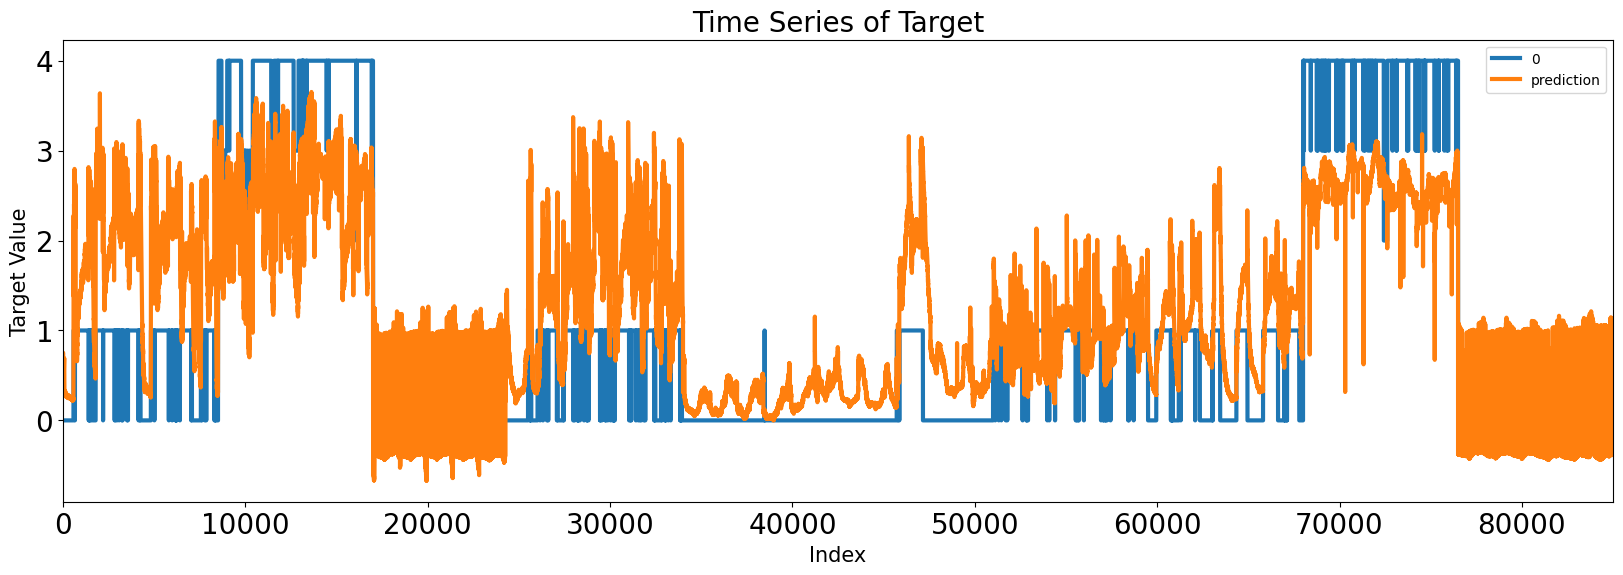

In [45]:
Score_GRU, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(y_train), Y_train_pred.flatten(), pd.DataFrame(y_test), Y_test_pred.flatten(), graph_on=True)

In [46]:
display(Score_GRU)

,MAE,MSE,MAPE
Train,0.632339,0.743520,inf
Test,0.715226,0.801465,inf
